In [1]:
import numpy as np
import numpy.random as nrand
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import yaml
import scipy.stats
import pickle

In [2]:
rcParams_dict = {
    'patch.edgecolor':'k',
    'patch.force_edgecolor': True,
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

(-0.01, 0.25)

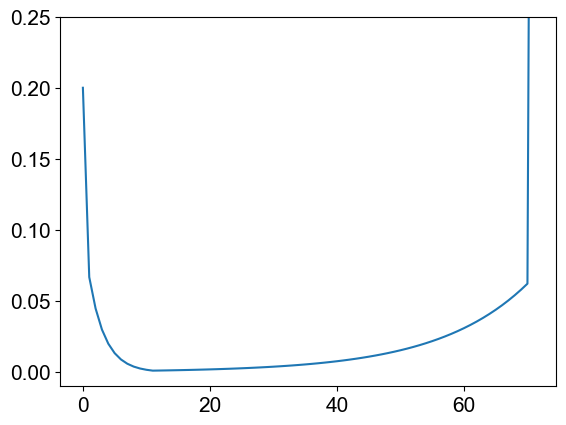

In [3]:
def get_moltality_curve(max_age=70):
    
    fold_change = (70 - 11) / (max_age - 11)
    x = np.linspace(0,71,72).astype(int)
    
    A = 0.1
    B = -0.4
    x1 = x[1:11]
    y1 = A*np.exp(B*x1) + (0.001 - A*np.exp(B*11))
    
    x2 = x[11:]
    y2 = 0.001*np.exp(0.07*(x2-11))
    
    y = np.array([0.2] + list(y1) + list(y2))
        
    y[max_age+1:] = 1
    return x, y
x,y = get_moltality_curve(max_age=70)
plt.plot(y)
plt.ylim(-0.01,0.25)

In [4]:
with open("options.yml",'r') as f:
    argv = yaml.load(f,Loader=yaml.FullLoader)
Primary_reproduction_rate_with_age_male = argv['Primary_reproduction_rate_with_age_male']
Primary_reproduction_rate_with_age_female = argv['Primary_reproduction_rate_with_age_female']
Primary_marriage_rate_with_age_female = argv['Primary_marriage_rate_with_age_female']
Primary_marriage_rate_with_age_male = argv['Primary_marriage_rate_with_age_male']
# Primary_mortality_with_age_female = argv['Primary_mortality_with_age_female']
# Primary_mortality_with_age_male = argv['Primary_mortality_with_age_male']
x,y = get_moltality_curve(max_age=70) 
Primary_mortality_with_age_female = dict(zip(x, y))
Primary_mortality_with_age_male = Primary_mortality_with_age_female



In [5]:
k_s = 0.5
x0_s = 4
L_s = 3

def survival_N_sib(N_sib):
    global k_s
    global x0_s
    global L_s
    if N_sib == x0_s:
        y = -k_s / L_s + 1 - k_s*x0_s/(1-np.exp(L_s*x0_s))
    else:
        y = -k_s*(N_sib - x0_s) / (1 - np.exp(-L_s * (N_sib - x0_s))) + 1 - k_s*x0_s/(1-np.exp(L_s*x0_s))
    return max(y, 0)

def marriage_N_sib(N_sib):
    k = 1
    x0 = 6
    y = -0.5 / (1 + np.exp(k * (x0 - N_sib))) + 1
    return y

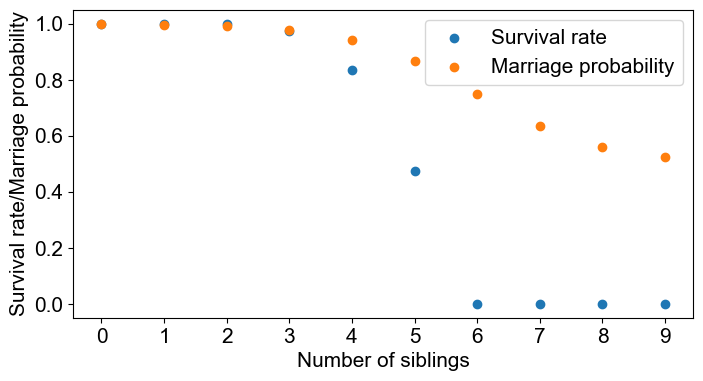

In [6]:
fig, ax = plt.subplots(figsize=[8, 4])
x = np.linspace(0,9,10)
y1 = [survival_N_sib(i) for i in x]
y2 = [marriage_N_sib(i) for i in x]
ax.scatter(x, y1, label='Survival rate')
ax.scatter(x, y2, label='Marriage probability')
ax.set_ylabel('Survival rate/Marriage probability')
ax.set_xlabel('Number of siblings')
ax.set_xticks(ticks=range(10),labels=range(10))
plt.legend()

In [6]:
random_list=nrand.random(size=10000000).tolist()
def get_random():
    global random_list
    if len(random_list) == 0:
        random_list=nrand.random(size=10000000).tolist()
    return random_list.pop()

In [8]:
class Allele:
    N=0
    def __init__(self,effect=0):
        self.index = Allele.N
        self.effect = effect
        Allele.N += 1

class People:
    destructed_people = 0
    created_people = 0
    #Age_cutoff = 25
    Male_age_cutoff = 25
    Female_age_cutoff = 20
    def __init__(self,sex,Paternal_allele,Maternal_allele,gen_of_birth,age=0,
                 N_sons=0,N_daughters=0,N_brothers=0,N_sisters=0,Mother=None,Father=None):
        self.Gen_of_birth = gen_of_birth
        self.Age = age
        self.Sex = sex #0-female, 1-male
        self.Paternal_allele = Paternal_allele
        self.Maternal_allele = Maternal_allele
        self.Resource = 1
        self.Menopause_age = 70 + np.min([self.Paternal_allele.effect, self.Maternal_allele.effect])
        self.N_sons = N_sons
        self.N_daughters = N_daughters
        self.N_birth = 0
        self.N_mature_children = 0
        self.offspring_list = []
        self.Mother = Mother
        self.Father = Father
        self.Partner = []
        self.N_Brother = 0
        self.N_Sister = 0
        self.sibling_list = []
        self.N_young_sib_list = []
        self.survival_rate = 1
        self.mating_willingness = self.get_mating_willingness()
        self.marry_willingness = self.get_marry_willingness()
        #self.uid = self.get_uid(self)
        People.created_people += 1
    
    def update(self):
        self.survival_rate = self.get_survival_rate()
        self.mating_willingness = self.get_mating_willingness()
        self.marry_willingness = self.get_marry_willingness()
        
    def mutate(self):
        mutant = Allele(effect=-nrand.randint(1,51))
        if get_random() < 0.5:
            self.Paternal_allele = mutant
        else:
            self.Maternal_allele = mutant
            
        self.Menopause_age = 70 + min(self.Paternal_allele.effect, self.Maternal_allele.effect)
        
    def update_N_young_sib_list(self):
        N_young_sib = 0
        for sib in self.sibling_list:
            if (sib.Sex == 0) and (sib.Age < People.Female_age_cutoff):
                N_young_sib += 1
            elif (sib.Sex == 1) and (sib.Age < People.Male_age_cutoff):
                N_young_sib += 1
                
        self.N_young_sib_list.append(N_young_sib)
    
    def get_sibling_effect_mortality(self):
        
        survival_rate_multiplier = np.mean([survival_N_sib(N_young_sib) for N_young_sib in self.N_young_sib_list])
        
        
        #survival_rate_multiplier = survival_N_sib(np.mean(self.N_young_sib_list))
        
        #survival_rate_multiplier = survival_N_sib(self.N_young_sib_list[0])
        #for N_sib in self.N_young_sib_list[1:]:
        #    survival_rate_multiplier = (survival_rate_multiplier + survival_N_sib(N_sib)) / 2
        
        return survival_rate_multiplier
    
    def get_survival_rate(self):
        if self.Sex == 0:
            primary_mortality = Primary_mortality_with_age_female[self.Age]
        else:
            primary_mortality = Primary_mortality_with_age_male[self.Age]
        
        _survival_rate = (1 - primary_mortality)
        
        if argv['Maternal_effect_mortality']:
            if (self.Mother is None) and (self.Age <= 10):
                _survival_rate = 1 - 10 * (1-_survival_rate)
        
        if argv['Sibling_effect_mortality']:
            survival_rate_multiplier = self.get_sibling_effect_mortality()
            _survival_rate = _survival_rate * survival_rate_multiplier
        
        return max(0,min(1,_survival_rate)) # ensure return 0<=_survival_rate<=1
    
    
    def get_sibling_effect_marriage(self):
        if len(self.N_young_sib_list) > 0:
            mating_willingness_multiplier = np.mean([marriage_N_sib(N_young_sib) for N_young_sib in self.N_young_sib_list])
        else:
            mating_willingness_multiplier = 1
        
        return mating_willingness_multiplier
    
    def get_marry_willingness(self):
        if self.Sex == 0:
            _marry_willingness = Primary_marriage_rate_with_age_female[self.Age]     
        else:
            _marry_willingness = Primary_marriage_rate_with_age_male[self.Age]
        
        if argv['Sibling_effect_marriage']:
            marry_willingness_multiplier = self.get_sibling_effect_marriage()
            _marry_willingness = _marry_willingness * marry_willingness_multiplier
            
        return max(0, min(1, _marry_willingness))
    
    
    def get_mating_willingness(self):
        if self.Sex == 0:
            _mating_willingness = Primary_reproduction_rate_with_age_female[self.Age]
            
            if self.Age >= self.Menopause_age:
                _mating_willingness = 0
            
            elif self.N_daughters + self.N_sons > 0:
                child_age_min = np.min([child.Age for child in self.offspring_list])
                if child_age_min < 4:
                    if not ((child_age_min == 3) and (get_random() < 0.5)):
                        _mating_willingness = 0
                    
        else:
            _mating_willingness = Primary_reproduction_rate_with_age_male[self.Age]
            
        return max(0, min(1, _mating_willingness))
    

    
    def __del__(self):
        #print('__del__')
        People.destructed_people += 1

class Population:
    def __init__(self, if_marriage=False):
        self.N_male = 0
        self.N_female = 0
        self.Male_list = []
        self.Female_list = []
        self.Dead_female_list = []
        self.Current_generation = 0
        self.MORTALITY_COEFFICIENT = 2e-12
        self.pop_survival_rate = 1
        self.update()
        self.N_people_died = 0
        self.if_marriage = if_marriage
        #self.allele_dict = init_allele_dict()
        self.empirical_mortality_dict = {np.int8(age):[] for age in range(0,72)}
        
    def Add_people(self, people):
        if people.Sex == 0:
            self.Female_list.append(people)
        else:
            self.Male_list.append(people)
    
#     def get_N_sex_with_age(self):
#         N_sex_with_age_dict = {'Male':[0]*self.max_age,'Female':[0]*self.max_age}
#         for people in self.Male_list:
#             N_sex_with_age_dict['Male'][people.Age] += 1
#         for people in self.Female_list:
#             N_sex_with_age_dict['Female'][people.Age] += 1
#         return N_sex_with_age_dict

    def get_mean_Menopause_age(self):
        Menopause_age_list = []
        for people in self.Female_list:
            Menopause_age_list.append(people.Menopause_age)
        return np.mean(Menopause_age_list)
    
    def marry(self): # Assuming polygyny
        Males_to_marry = []
        Females_unmarried = []
        for people in self.Male_list:
            if get_random() < people.marry_willingness:
                Males_to_marry.append(people)
        for people in self.Female_list:
            if (len(people.Partner) == 0) and (get_random() < people.marry_willingness):
                Females_unmarried.append(people)
        nrand.shuffle(Males_to_marry)
        for i in range(min(len(Males_to_marry),len(Females_unmarried))):
            Males_to_marry[i].Partner.append(Females_unmarried[i])
            Females_unmarried[i].Partner.append(Males_to_marry[i])
            
    def mate2people(self, Male, Female):
        
        if get_random() < 0.5:
            sex = 1
            Male.N_sons += 1
            Female.N_sons += 1
        else:
            sex = 0
            Male.N_daughters += 1
            Female.N_daughters += 1
        
        Female.N_birth += 1
        
        Paternal_allele = Male.Paternal_allele if get_random() < 0.5 else Male.Maternal_allele
        Maternal_allele = Female.Paternal_allele if get_random() < 0.5 else Female.Maternal_allele
        
        offspring = People(sex,Paternal_allele,Maternal_allele,
                           gen_of_birth=self.Current_generation,age=0,
                           Mother=Female,Father=Male)
            
        for sibling in Female.offspring_list: # Only account for maternal siblings
            if sex == 0:
                sibling.N_Sister += 1
            else:
                sibling.N_Brother += 1
            sibling.sibling_list.append(offspring)
            offspring.sibling_list.append(sibling)
        
        Male.offspring_list.append(offspring)
        Female.offspring_list.append(offspring)
        
        if sex == 0:
            self.Female_list.append(offspring)
        else:
            self.Male_list.append(offspring)
        
    def reproduce(self):
        for people in self.Female_list:
            if (len(people.Partner) > 0) and (get_random() < people.mating_willingness):
                self.mate2people(people.Partner[0], people)
        
    def next_generation(self):
        Male_list_new = []
        Female_list_new = []
        
        for people in [*self.Male_list, *self.Female_list]:
            if (people.Sex == 0) and (people.Age < People.Female_age_cutoff):
                people.update_N_young_sib_list()
            elif (people.Sex == 1) and (people.Age < People.Male_age_cutoff):
                people.update_N_young_sib_list()

            if not self.if_marriage:     # random mating
                people.Partner = []
                
            people.survival_rate = people.get_survival_rate()

            if self.Current_generation > 100:
                self.empirical_mortality_dict[np.int8(people.Age)].append(people.survival_rate)
            
        # If there are too many individuals, keep ~1000 of them.
        if self.N_male + self.N_female > 20000000:
            self.pop_survival_rate = 1000/(self.N_male + self.N_female)
        else:
            self.pop_survival_rate = 1
        
        for sex,Pop_list in zip(['Male', 'Female'],[self.Male_list, self.Female_list]):
            for people in Pop_list:
                
                if get_random() < people.survival_rate - (1 - self.pop_survival_rate):
                    # Survived
                    people.Age += 1
                    if sex == 'Male':
                        Male_list_new.append(people)
                    else:
                        Female_list_new.append(people)
                        
                else:
                    # Died
                    # remove the individual from Mother
                    if people.Mother is not None:
                        if sex == 'Male':
                            people.Mother.N_sons -= 1
                        else:
                            people.Mother.N_daughters -= 1
                        people.Mother.offspring_list.remove(people)
                        assert people not in people.Mother.offspring_list
                        
                    # remove the individual from Father
                    if people.Father is not None:
                        if sex == 'Male':
                            people.Father.N_sons -= 1
                        else:
                            people.Father.N_daughters -= 1
                        people.Father.offspring_list.remove(people)
                        assert people not in people.Father.offspring_list
                        
                    # remove the individual from offspring
                    for offspring in people.offspring_list:
                        if sex == 'Male':
                            offspring.Father = None
                        else:
                            offspring.Mother = None
                    
                    # remove the individual from sibling
                    for sibling in people.sibling_list:
                        if sex == 'Male':
                            sibling.N_Brother -= 1
                        else:
                            sibling.N_Sister -= 1
                        sibling.sibling_list.remove(people)
                        assert people not in sibling.sibling_list
                    
                    # remove the individual from partner
                    
                    for partner in people.Partner:
                        partner.Partner.remove(people)
                        assert people not in partner.Partner
                    
                    self.N_people_died += 1
                    #print('people died')
                        
        self.Male_list = Male_list_new
        self.Female_list = Female_list_new
        
        for people in [*self.Male_list, *self.Female_list]:
            people.mating_willingness = people.get_mating_willingness()
            people.marry_willingness = people.get_marry_willingness()
        
        self.marry()
        
        self.Current_generation += 1
        
        self.update()
    
    def get_allele_dict(self):
        allele_dict = {}
        for Pop in [self.Male_list,self.Female_list]:
            for people in Pop:
                if people.Paternal_allele.index in allele_dict:
                    allele_dict[people.Paternal_allele.index] += 1
                else:
                    allele_dict[people.Paternal_allele.index] = 1
                if people.Maternal_allele.index in allele_dict:
                    allele_dict[people.Maternal_allele.index] += 1
                else:
                    allele_dict[people.Maternal_allele.index] = 1
        return allele_dict
    
    def update(self):
        self.N_female = len(self.Female_list)
        self.N_male = len(self.Male_list)
        # self.N_sex_with_age = self.get_N_sex_with_age()
        # self.pop_survival_rate = max(0,1-(self.MORTALITY_COEFFICIENT)*(self.N_female+self.N_male)**2)

        
        

In [9]:
allele_list = []
for effect in [-30, 0]:
    allele_list.append(Allele(effect=effect))

In [10]:
# initialize population
Allele.N = 0
People.created_people = 0
People.destructed_people = 0
#default_allele = Allele(effect=0)
default_allele = allele_list[0]
#default_allele = allele_list[1]

Pop = Population()
for sex in [0,1]:
    for age in range(10):
        for i in range(200):
            people = People(sex=sex,Paternal_allele=default_allele,Maternal_allele=default_allele,gen_of_birth=-age,age=age)
            Pop.Add_people(people)

# for effect in [-10, -15, -20, -25, -30 ,-35, -40]:
#     allele_ = Allele(effect=effect)
#     for sex in [0,1]:
#         for age in range(10):
#             for i in range(10):
#                 people = People(sex=sex,Paternal_allele=allele_,Maternal_allele=allele_,gen_of_birth=-age,age=age)
#                 Pop.Add_people(people)

# for effect in [0]:
#     allele_ = Allele(effect=effect)
#     for sex in [0,1]:
#         for age in range(10):
#             for i in range(50):
#                 people = People(sex=sex,Paternal_allele=allele_,Maternal_allele=allele_,gen_of_birth=-age,age=age)
#                 Pop.Add_people(people)

people=None
Pop.MORTALITY_COEFFICIENT = argv['MORTALITY_COEFFICIENT']


In [11]:
allele_list_dict={}
N_list = []
sex_ratio_list = []
sex_ratio_at_birth_list = []

N_birth_list = []
N_children_list = []
N_birth_WT_list = []
N_children_WT_list = []
N_birth_MT_list = []
N_children_MT_list = []

In [12]:
Menopause_age_list = []

for ii in range(171):
    print(f'{ii}   ',end='\r')
    Pop.reproduce()
    Pop.next_generation()
    N_list.append(Pop.N_male+Pop.N_female)
    #allele_dict = Pop.get_allele_dict()
    
    #if Pop.N_female + Pop.N_male > 100000:
    #    break

    
    
    # for key,value in allele_dict.items():
    #     if key in allele_list_dict:
    #         allele_list_dict[key].append(value)
    #     else:
    #         allele_list_dict[key] = [value]
            
    #Menopause_age_list.append(Pop.get_mean_Menopause_age())
    
    #if People.created_people - People.destructed_people - (Pop.N_male+Pop.N_female)  >20000:
    #    break
    #if (Pop.N_male+Pop.N_female)>200000:
    #    break
        
    # if (ii % 10 == 0) and (ii > 100) and (Pop.N_male+Pop.N_female > 5000):
    #     for people in Pop.Female_list:
    #         if people.Age >= 40: # >= 40
    #             N_birth_list.append(people.N_birth)
                
    #             N_children = 0
    #             for child in people.offspring_list:
    #                 if child.Age >= 10: # 10
    #                     N_children += 1
    #             N_children_list.append(N_children)
                
    #             if people.Menopause_age == 40:
    #                 N_birth_MT_list.append(people.N_birth)
    #                 N_children_MT_list.append(people.N_sons+ people.N_daughters)
                    
    #             elif people.Menopause_age == 70:
    #                 N_birth_WT_list.append(people.N_birth)
    #                 N_children_WT_list.append(people.N_sons+ people.N_daughters)
                    
    #assert Pop.N_people_died == People.destructed_people, "miss to deconstruct died people"

In [15]:
empirical_mortality_dict = Pop.empirical_mortality_dict
empirical_mortality_list = []
for i in range(0,71):
    age = np.int8(i)
    empirical_mortality_list.append(1-np.mean(empirical_mortality_dict[age]))

In [16]:
A = [0.216, 0.063, 0.031, 0.038, 0.035, 0.019, 0.006, 0.014, 0.035, 0.007, 0.022, 
     0.007, 0.015, 0.008, 0.008, 0.008, 0.008, 0.009, 0.000, 0.020, 0.010, 0.019, 
     0.000, 0.000, 0.000, 0.000, 0.000, 0.023, 0.000, 0.012, 0.011, 0.000, 0.000, 
     0.011, 0.000, 0.000, 0.029, 0.000, 0.016, 0.036, 0.020, 0.021, 0.000, 0.000, 
     0.000, 0.024, 0.045, 0.000, 0.000, 0.024, 0.000, 0.044, 0.024, 0.023, 0.022, 
     0.019, 0.000, 0.018, 0.000, 0.019, 0.020, 0.024, 0.000, 0.044, 0.000, 0.000,
     0.108, 0.028, 0.000, 0.097, 0.048, 0.053, 0.056, 0.176, 0.167, 0.300, 0.091, 
     0.300, 0.167, 0.200, 0.000, 0.500, 0.000, 0.000, 0.500, 0.000, 1.000, 0.000,
     0.000, 0.000, 0.000]

len(A)

91

(-0.01, 0.25)

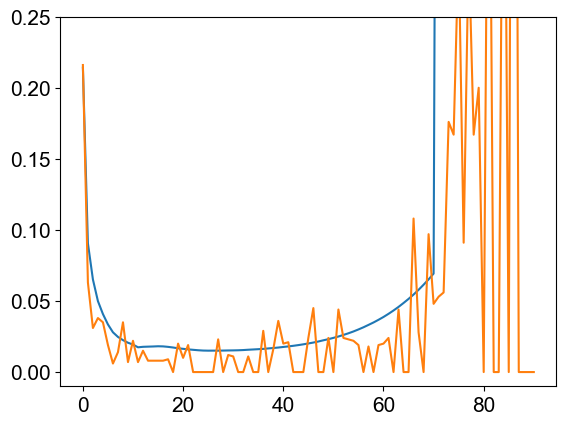

In [19]:
plt.plot(empirical_mortality_list+[1])
#plt.plot(y)
plt.plot(range(91), A)
plt.ylim(-0.01, 0.25)

In [22]:
A = 0.214103673818001
B = 0.09061197984042635
C = 0.0651520841048473
D = 0.04991691777719387
A + (1-A)*B + (1-A)*(1-B)*C + (1-A)*(1-B)*(1-C)*D

0.3652290601222443

In [14]:
N_birth_list = []
N_mature_children_list = []
for people in Pop.Dead_female_list:
    N_birth_list.append(people.N_birth)
    N_mature_children_list.append(people.N_mature_children)
    
N_birth_list = np.array(N_birth_list)
N_mature_children_list = np.array(N_mature_children_list)

In [15]:
N_mature_children_mean_list = []
N_mature_children_se_list = []
for i in range(np.min(N_birth_list), np.max(N_birth_list)):
    idx = N_birth_list == i
    N_mature_children_mean_list.append(np.mean(N_mature_children_list[idx]))
    N_mature_children_se_list.append(np.std(N_mature_children_list[idx])/np.sqrt(len(N_mature_children_list[idx])))

ValueError: zero-size array to reduction operation minimum which has no identity

In [150]:
# resut_dict = {
#     'N_birth_list': N_birth_list, 
#     'N_mature_children_list': N_mature_children_list, 
#     'N_mature_children_mean_list': N_mature_children_mean_list,
#     'N_mature_children_se_list': N_mature_children_se_list
# }

# with open('./NB_NC_curve_nonmenopause_pop.pkl', 'wb') as f:
#     pickle.dump(resut_dict, f)

Text(0, 0.5, 'Number of children survived until mature')

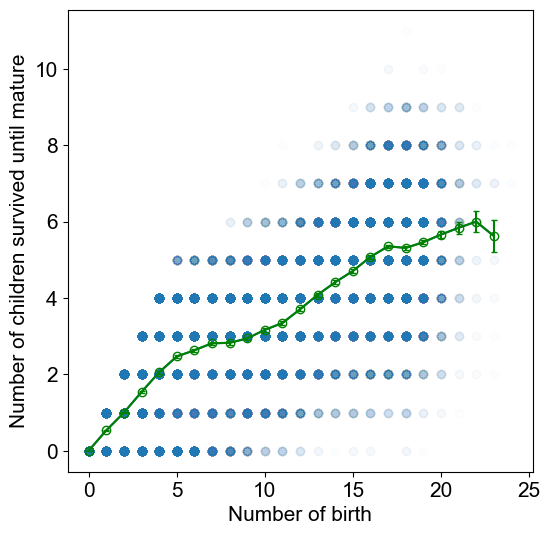

In [151]:
# k_s = 0.5
# x0_s = 5
# L_s = 3

plt.subplots(figsize=[6,6])
plt.scatter(N_birth_list, N_mature_children_list, alpha = 0.01)
plt.plot(range(np.min(N_birth_list), np.max(N_birth_list)), N_mature_children_mean_list, 'go-', markerfacecolor='none')
plt.errorbar(range(np.min(N_birth_list), np.max(N_birth_list)), N_mature_children_mean_list, yerr=N_mature_children_se_list, 
             ecolor='g', barsabove=True, capsize=2)

plt.xlabel('Number of births')
plt.ylabel('Number of children surviving to maturity')

In [154]:
with open('./NB_NC_curve_menopause_pop.pkl', 'rb') as f:
    resut_dict_menopause = pickle.load(f)

N_birth_list = resut_dict_menopause['N_birth_list']
N_mature_children_list = N_mature_children_list = resut_dict_menopause['N_mature_children_list']
N_mature_children_mean_list = resut_dict_menopause['N_mature_children_mean_list']
N_mature_children_se_list = resut_dict_menopause['N_mature_children_se_list']

(-1.0, 20.0)

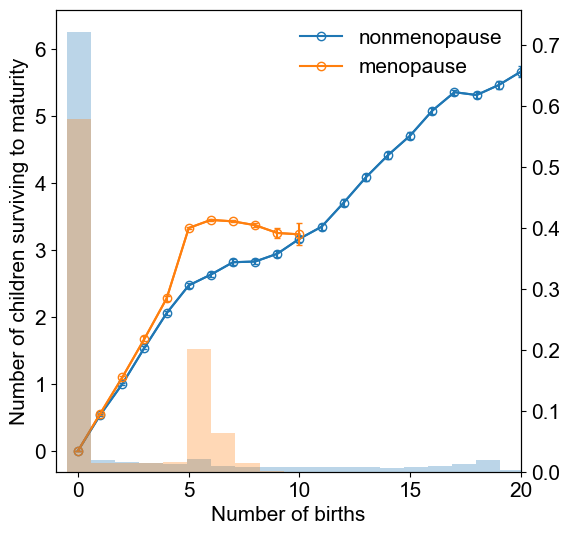

In [208]:
fig, ax1 = plt.subplots(figsize=[6,6])
ax2 = ax1.twinx()
#plt.scatter(N_birth_list, N_mature_children_list, alpha = 0.01)
for i, file_suffix in enumerate(['nonmenopause', 'menopause']):
    with open(f'./NB_NC_curve_{file_suffix}_pop.pkl', 'rb') as f:
        resut_dict_menopause = pickle.load(f)
        
    N_birth_list = resut_dict_menopause['N_birth_list']
    N_mature_children_list = N_mature_children_list = resut_dict_menopause['N_mature_children_list']
    N_mature_children_mean_list = resut_dict_menopause['N_mature_children_mean_list']
    N_mature_children_se_list = resut_dict_menopause['N_mature_children_se_list']
    
    ax1.plot(range(np.min(N_birth_list), np.max(N_birth_list)), N_mature_children_mean_list,
             'o-', color=f'C{i}', markerfacecolor='none', label=file_suffix)
    ax1.errorbar(range(np.min(N_birth_list), np.max(N_birth_list)), N_mature_children_mean_list, yerr=N_mature_children_se_list, 
                 ecolor=f'C{i}', barsabove=True, capsize=2)
    
    #N_birth_list_gt0 = N_birth_list[N_birth_list>0]
    ax2.hist(N_birth_list, bins=23, range=[-0.5,24.5], density=True, alpha=0.3, edgecolor='none')

#ax2.set_ylim(0,1)
ax1.set_xlabel('Number of births')
ax1.set_ylabel('Number of children surviving to maturity')
ax1.legend(loc='upper right', frameon=False)
plt.xlim(-1,20)

In [193]:
np.max(N_birth_list)

24

Mean number of mature children (age > 20) = 0.830154107277181


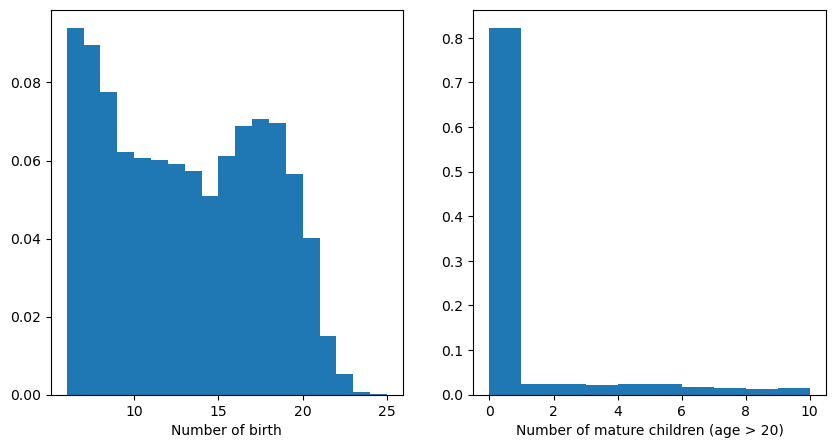

In [15]:
fig, axes = plt.subplots(1, 2, figsize=[10,5])
ax1, ax2 = axes
ax1.hist(N_birth_list, range=[6,25], density=True, bins=19)
ax2.hist(N_mature_children_list, range=[0,10], density=True, bins=10)
ax1.set_xlabel('Number of birth')
ax2.set_xlabel('Number of mature children (age > 20)')
print(f'Mean number of mature children (age > 20) = {np.mean(N_mature_children_list)}')

Mean number of mature children (age > 20) = 1.0515839708386292


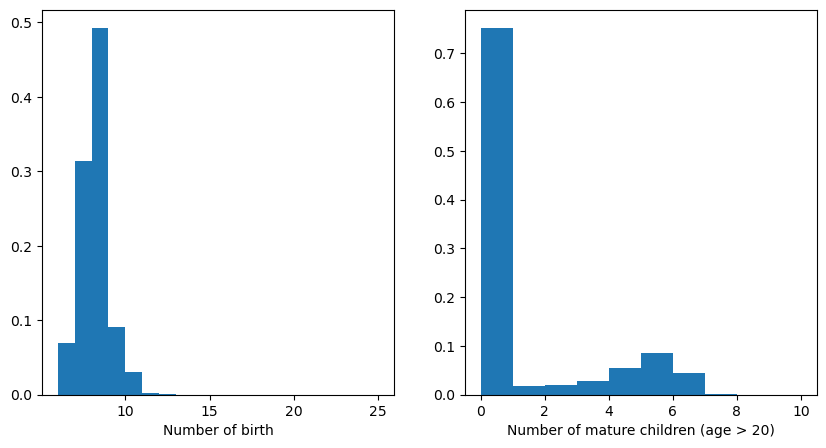

In [14]:
fig, axes = plt.subplots(1, 2, figsize=[10,5])
ax1, ax2 = axes
ax1.hist(N_birth_list, range=[6,25], density=True, bins=19)
ax2.hist(N_mature_children_list, range=[0,10], density=True, bins=10)
ax1.set_xlabel('Number of birth')
ax2.set_xlabel('Number of mature children (age > 20)')
print(f'Mean number of mature children (age > 20) = {np.mean(N_mature_children_list)}')

Text(0, 0.5, 'Number of children')

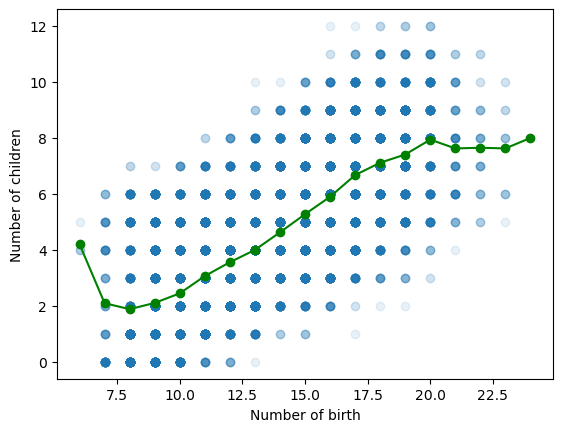

In [13]:
plt.scatter(N_birth_list, N_mature_children_list, alpha = 0.1)
plt.plot(range(np.min(N_birth_list), np.max(N_birth_list) + 1), N_mature_children_mean_list, 'go-')
plt.xlabel('Number of birth')
plt.ylabel('Number of children')

In [11]:
N_birth_list = np.array(N_birth_list)
N_children_list = np.array(N_children_list)

/home/siliang/miniconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/siliang/miniconda3/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0.5, 0, 'Number of children (age > 10)')

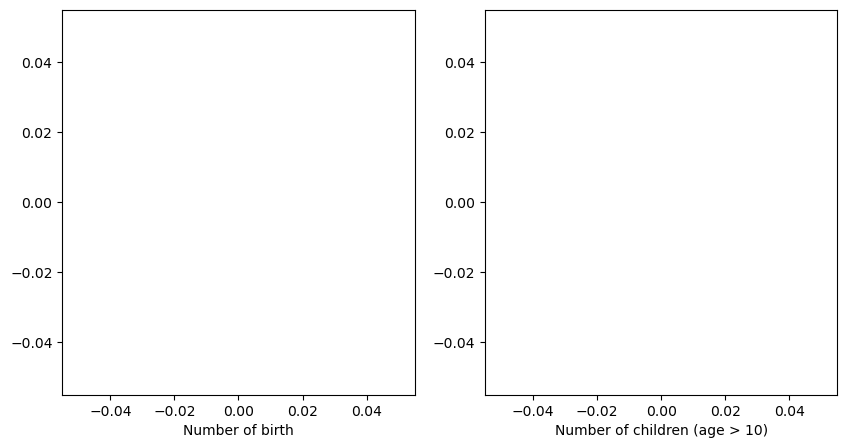

In [12]:
fig, axes = plt.subplots(1, 2, figsize=[10,5])
ax1, ax2 = axes
ax1.hist(N_birth_WT_list, range=[6,25], density=True, bins=19)
ax2.hist(N_children_WT_list, range=[0,10], density=True, bins=10)
ax1.set_xlabel('Number of birth')
ax2.set_xlabel('Number of children (age > 10)')

In [14]:
np.mean(N_birth_list)

11.875674765253274

In [15]:
np.mean(N_children_list)

4.2168259716198575

Text(0.5, 0, 'Number of children (age > 10)')

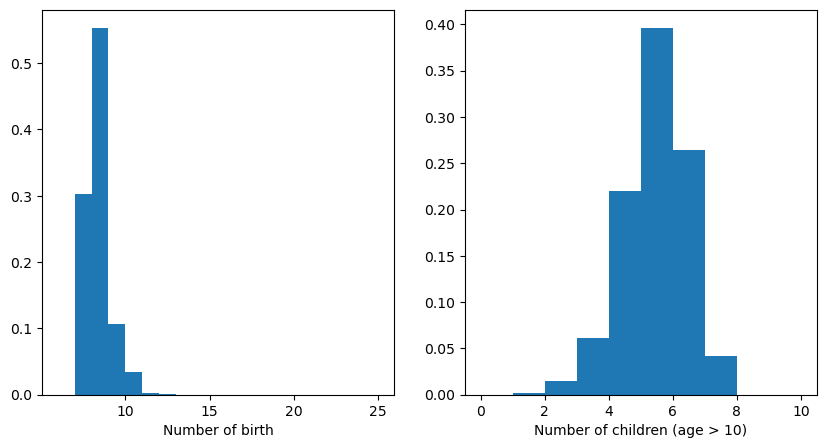

In [15]:
fig, axes = plt.subplots(1, 2, figsize=[10,5])
ax1, ax2 = axes
ax1.hist(N_birth_MT_list, range=[6,25], density=True, bins=19)
ax2.hist(N_children_MT_list, range=[0,10], density=True, bins=10)
ax1.set_xlabel('Number of birth')
ax2.set_xlabel('Number of children (age > 10)')

In [23]:
# Set matplotlib parameters for consistent styling
rcParams_dict = {
    'xtick.bottom': True,
    'patch.edgecolor':'k',
    'patch.force_edgecolor': True,
    'font.size': 12,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

In [11]:
A = [0.216, 0.063, 0.031, 0.038, 0.035, 0.019, 0.006, 0.014, 0.035, 0.007, 0.022, 
     0.007, 0.015, 0.008, 0.008, 0.008, 0.008, 0.009, 0.000, 0.020, 0.010, 0.019, 
     0.000, 0.000, 0.000, 0.000, 0.000, 0.023, 0.000, 0.012, 0.011, 0.000, 0.000, 
     0.011, 0.000, 0.000, 0.029, 0.000, 0.016, 0.036, 0.020, 0.021, 0.000, 0.000, 
     0.000, 0.024, 0.045, 0.000, 0.000, 0.024, 0.000, 0.044, 0.024, 0.023, 0.022, 
     0.019, 0.000, 0.018, 0.000, 0.019, 0.020, 0.024, 0.000, 0.044, 0.000, 0.000,
     0.108, 0.028, 0.000, 0.097, 0.048, 0.053, 0.056, 0.176, 0.167, 0.300, 0.091, 
     0.300, 0.167, 0.200, 0.000, 0.500, 0.000, 0.000, 0.500, 0.000, 1.000, 0.000,
     0.000, 0.000, 0.000]

In [7]:
mortality_curve_list = []
for k in [0.15, 0.2, 0.3, 0.5, 1.0]:
    for x0 in [4, 4.5, 5, 5.5, 6]:
        for L in [1.1, 1.5, 2.0, 3.0, 5.0]:
            df = pd.read_csv(f'./empirical_mortality_curve/results/{k}_{x0:.1f}_{L}.txt', header=None)
            if df.iloc[0,0] != 'failed':
                mortality_curve_list.append(df[0].tolist())

In [8]:
mortality_curve_array = np.array(mortality_curve_list)

In [9]:
mortality_curve_mean = mortality_curve_array.mean(axis=0)
mortality_curve_lower = np.percentile(mortality_curve_array, q=2.5, axis=0)
mortality_curve_upper = np.percentile(mortality_curve_array, q=97.5, axis=0)

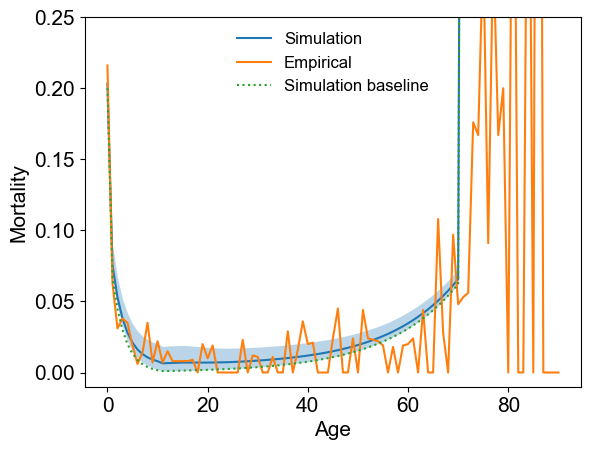

In [30]:
plt.plot(list(mortality_curve_mean) + [1], label='Simulation')
plt.fill_between(range(71) ,mortality_curve_lower, mortality_curve_upper, alpha=0.3,lw=0)
x,y = get_moltality_curve(max_age=70)

plt.plot(A, label='Empirical')
plt.plot(y, ':', label='Simulation baseline')
plt.ylim(-0.01,0.25)
plt.ylabel('Mortality')
plt.xlabel('Age')
plt.legend(frameon=False, fontsize=12)

plt.savefig('./Figures/Martality_curve.pdf')

(-0.01, 0.25)

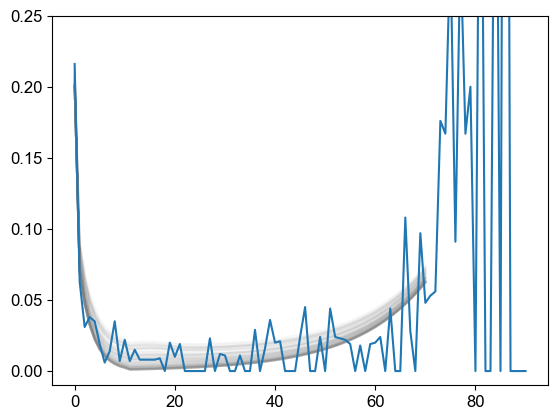

In [72]:
for mortality_curve in mortality_curve_list:
    plt.plot(mortality_curve, c='grey', alpha=0.05)
plt.plot(A)
plt.ylim(-0.01, 0.25)

In [ ]:
#scipy.stats.ttest_1samp(sex_ratio_at_birth_list[0:100],1)